# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

# XOR probléma

Az előzőleg bemutatott XOR problémát e notebookban egy Python alapokra építkező, gépi tanulást elősegítő keretrendszerrel, a Kerassal fogjuk megoldani. A Keras az egyik legelterjedtebb mély tanuló keretrendszer, köszönhetően magas szintű megvalósításának. Backend-nek TensorFlow-t és Thenao-t is tud használni.
A kódunk elején betöltjük a Keras csomagból a szükséges modulokat.

In [4]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from tensorflow.keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from tensorflow.keras.layers import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni. 
from tensorflow.keras.callbacks import Callback, TensorBoard
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from tensorflow.keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Standardizáláshoz
from sklearn import preprocessing
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt

# Random seed beállítása
np.random.seed(1)

Az előbb már említett Callback függvényre alapozva a TrainingHistory osztállyal tudunk kinyerni értékes metrikákat, amelyek a hálózat tanulási folyamatát jellemzik. 

In [5]:
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [6]:
# Modell felépítése
from keras import regularizers
# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(10, input_shape=(2,)))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(1))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])

Tanító, validációs és tesztelő adatok megadása, standardizálása és megjelenítése:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  after removing the cwd from sys.path.


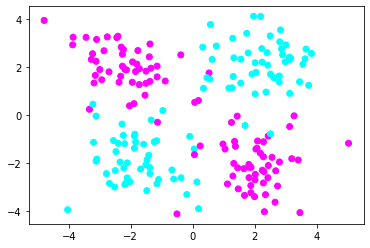

In [7]:
nb_samples=200
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
    
# standardizálás
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

A továbbiakban un. callback függvényeket adunk meg, melyeket tanítás során hív meg a Keras deep learning keretrendszer:

In [8]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

In [10]:
tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


# A háló tanítása és tesztelése

Tanítási folyamat és annak a paraméterei. A paraméterek sorát a tanulási adatokkal kell kezdeni. Ez után számos paramétert definiálhatunk, melyek rövid magyarázatát kommentekben olvashatjátok:

In [12]:
model.fit(samples_train['input'], samples_train['output'],
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=20,
          # Tanulási fázisok száma.
          epochs=2500,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Értéke lehet 0, 1 és 2
          verbose=2, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(samples_valid['input'],samples_valid['output']), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[reduce_lr, checkpointer, early_stopping, history, tensorboard_callback], 
          # A bemenő adatokat keverje meg a program (alapbeállítás: True).
          shuffle= True)

Epoch 1/2500
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: val_loss improved from inf to 0.24901, saving model to weights.hdf5
7/7 - 0s - loss: 0.3362 - accuracy: 0.4500 - val_loss: 0.2490 - val_accuracy: 0.5500
Epoch 2/2500

Epoch 00002: val_loss improved from 0.24901 to 0.24002, saving model to weights.hdf5
7/7 - 0s - loss: 0.2464 - accuracy: 0.5429 - val_loss: 0.2400 - val_accuracy: 0.6250
Epoch 3/2500

Epoch 00003: val_loss improved from 0.24002 to 0.23285, saving model to weights.hdf5
7/7 - 0s - loss: 0.2321 - accuracy: 0.6000 - val_loss: 0.2328 - val_accuracy: 0.6750
Epoch 4/2500

Epoch 00004: val_loss improved from 0.23285 to 0.21975, saving model to weights.hdf5
7/7 - 0s - loss: 0.2243 - accuracy: 0.6571 - val_loss: 0.2198 - val_accuracy: 0.6750
Epoch 5/2500

Epoch 00005: val_loss improved from 0.21975 to 0.21031, saving model to weights.hdf5
7/7 - 0s - loss: 0.2122 - accuracy: 0.7000 - val_loss: 0.2103 - val_accuracy: 0.7250
Epoch 6/2500

A hálózat hibájának megjelenítése mint a tanító, mind a validációs adathalmazon:

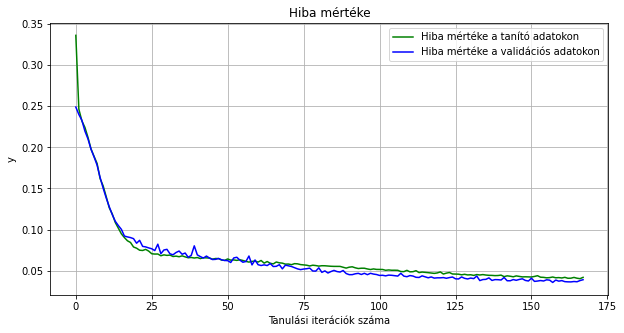

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Tesztelés és megjelenítés fázisa:

Test MSE: 0.085188


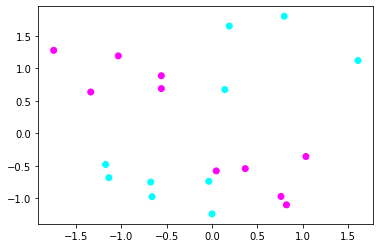

In [14]:
# a legjobb modell visszatöltése
from keras.models import load_model
model = load_model('weights.hdf5')
# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:,0]), cmap=plt.cm.cool)

# A modell vizsgálata

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('Rétegek:\n')
for layer in model.layers:
    print("Réteg neve: ", layer.name, ', tanítható: ', layer.trainable)
    print(layer.get_config(),'\n')

Rétegek:

Réteg neve:  dense , tanítható:  True
{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 10, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Réteg neve:  activation , tanítható:  True
{'name': 'activation', 'trainable': True, 'dtype': 'float32', 'activation': 'tanh'} 

Réteg neve:  dense_1 , tanítható:  True
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': Non

In [18]:
print("Súlyok:")
i=0
for layer in model.layers:
    print(model.get_layer(index=i).get_weights())
    i=i+1

Súlyok:
[array([[-1.1132982 ,  0.91418874,  0.33670413,  1.248441  ,  0.7655846 ,
        -0.5685106 ,  0.43758762, -0.6134678 , -0.23500486, -0.23445298],
       [-1.0522449 ,  1.1179367 , -1.1344829 , -0.26735094, -0.34990886,
        -0.5609605 ,  0.3962297 ,  0.61603725,  0.82495487, -0.3420721 ]],
      dtype=float32), array([-0.6122738 , -0.60420924,  0.69239825,  0.68226373, -0.3385138 ,
        0.23404048,  0.33103642,  0.532131  ,  0.27278692,  0.39331743],
      dtype=float32)]
[]
[array([[-1.1326171 ],
       [-0.9195897 ],
       [-0.8069439 ],
       [-0.9411497 ],
       [ 0.42791283],
       [ 0.1865891 ],
       [ 0.57970047],
       [-0.7529411 ],
       [-0.39304328],
       [ 0.55099297]], dtype=float32), array([0.7712255], dtype=float32)]
[]


## TensorBoard-os logok vizsgálata

In [19]:
%load_ext tensorboard


In [ ]:
%tensorboard --logdir logs

# Feladat

Vizsgáljátok meg L1 és L2 regularizáció hatását a súly mátriuxra. 

Segítség:

```
from keras import regularizers
model.add(Dense(10, input_shape=(2,), kernel_regularizer=regularizers.l2(0.1)))
...
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.1)))
```